In [1]:
print('''
This notebook is a playground for xgboost lib.
Code and data used here are partionally taken from :
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

''')


This notebook is a playground for xgboost lib.
Code and data used here are partionally taken from :
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f




In [2]:
from XGBoost.XGBoostOptimizer import XGBoostOptimizer

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error ,r2_score
import scipy.stats as stats
import math
from tqdm import tqdm
plt.style.use('ggplot')

In [4]:
#Read initial data
file = '~/csv/Social/Faceboo_comment_volume/Training/Features_Variant_1.csv'
df = pd.read_csv(file, header=None)
print("Dataset has {} entries and {} features".format(*df.shape))
df.sample(n=5)

Dataset has 40949 entries and 54 features


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
23622,313452,1,86759,8,0.0,1263.0,206.791304,135.0,235.597464,0.0,...,0,0,0,0,0,1,0,0,0,8
6620,1422427,0,35610,9,0.0,206.0,33.421622,20.0,38.486299,0.0,...,0,0,0,0,0,0,1,0,0,0
2097,329587,0,11271,4,0.0,97.0,12.101190,7.0,15.935749,0.0,...,0,1,0,1,0,0,0,0,0,0
1068,14032442,6,35154,20,1.0,762.0,76.949153,45.5,113.921311,0.0,...,0,0,0,0,0,0,1,0,0,22
12632,749554,0,68390,8,9.0,645.0,140.076923,81.5,149.898151,0.0,...,0,0,0,0,1,0,0,0,0,4


In [5]:
#Prepare data for fit to the model, split for evaluation 

X, y = df.loc[:,:52].values, df.loc[:,53].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.1, random_state=42)

#Transform to xgb native dtype
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [8]:
#Building a baseline model
def baseline_mode(X_train,y_train,y_test):
    # "Learn" the mean from the training data
    mean_train = np.mean(y_train)
    # Get predictions on the test set
    baseline_predictions = np.ones(y_test.shape) * mean_train
    # Compute MAE
    return mean_train , mean_absolute_error(y_test, baseline_predictions)

def print_baseline_dist(mu,sigma):
    x = np.linspace(mu - 3*sigma, mu+ 3*sigma,100)
    plt.plot(x,stats.norm.pdf(x,mu,sigma))
    plt.title('Expected comments distribution')
    plt.xlim(xmin=0,xmax=40)
    plt.xlabel('# comments')
    plt.ylabel('Probability')
    plt.show()
    
def xgb_mape(preds, dtrain):
    labels = dtrain.get_label()
    return('mape', np.mean(np.abs((labels - preds) / (labels+1))))

Baseline MAE:  11.30521959965711 
Baseline mean prediction:  7.278938514136865


/home/vlad/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/home/vlad/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


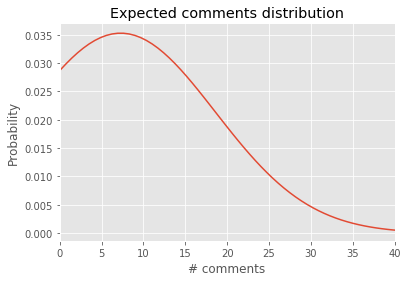

In [10]:
bl_mean , bl_var = baseline_mode(X_train,y_train,y_test)
print('Baseline MAE: ',bl_var,'\nBaseline mean prediction: ',bl_mean)
print_baseline_dist(bl_mean,bl_var)

In [11]:
#XGBoost training
###############################
#Define parameters for the model
params = {
    
    #--------
    #those parameters can be used to control the complexity of the trees. 
    #It is important to tune them together in order to find a good trade-off between model bias and variance
    
    #the maximum number of nodes allowed from the root to the farthest leaf of a tree
    'max_depth':6,
    #the minimum weight (or number of samples if all samples have a weight of 1) required in order to create a new node in the tree.
    #A smaller min_child_weight allows the algorithm to create children that correspond to fewer samples.
    'min_child_weight': 1,
    

    #--------
    #Instead of using the whole training set every time, we can build a tree on slightly different data at each step, which makes it less likely to overfit to a single sample or feature.
    
    # corresponds to the fraction of observations (the rows) to subsample at each step.
    'subsample': 1,
    # corresponds to the fraction of features (the columns) to use
    'colsample_bytree': 1,
    #--------
    # Other parameters
    
    #controls the learning rate. It corresponds to the shrinkage of the weights associated to features after each round
    # having a lower eta makes our model more robust to overfitting thus, usually, the lower the learning rate, the best
    # But with a lower eta, we need more boosting rounds,
    'eta':.3,
    
    # Model type
    'objective':'reg:squarederror',
    #evaluation metric for the tree
    'eval_metric' : 'mae'
}

#The number of boosting rounds or trees to build. 
#Its optimal value highly depends on the other parameters, and thus it should be re-tuned each time you update a parameter.
#It could be done by tuning it together with all parameters in a grid-search.
num_boost_round = 999

#If performance haven’t improved for N rounds we stop the training and keep the best number of boosting rounds.
early_stopping_round = 10

# Evaluating dataset to calculate the tree performance in the format (test_dmatrix, name_of_test)
evals = [(dtest, "Test")]


# Run XGBoost 

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    early_stopping_rounds=early_stopping_round
)
r_sqr = r2_score(y_pred=model.predict(dtest),y_true=y_test)

print("Best MAE: {:.2f} with {} rounds\n R^2 = {}".format(
                 model.best_score,
                 model.best_iteration+1,
                 round(r_sqr,2)))

[0]	Test-mae:5.97479
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:5.03358
[2]	Test-mae:4.64571
[3]	Test-mae:4.42331
[4]	Test-mae:4.39328
[5]	Test-mae:4.35545
[6]	Test-mae:4.31316
[7]	Test-mae:4.33087
[8]	Test-mae:4.37164
[9]	Test-mae:4.38773
[10]	Test-mae:4.39443
[11]	Test-mae:4.40662
[12]	Test-mae:4.39125
[13]	Test-mae:4.39087
[14]	Test-mae:4.39828
[15]	Test-mae:4.39103
[16]	Test-mae:4.40306
Stopping. Best iteration:
[6]	Test-mae:4.31316

Best MAE: 4.31 with 7 rounds
 R^2 = 0.69


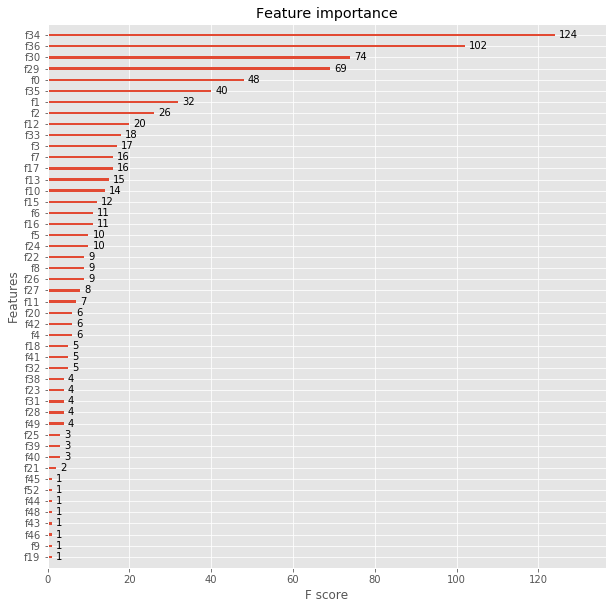

In [12]:
fig = plt.figure(figsize=(10,10))
xgb.plot_importance(booster=model,ax=fig.gca())

In [21]:
params = {'colsample_bytree': 1,
 'eta': 0.3,
 'eval_metric': 'mae',
 'max_depth': 6,
 'min_child_weight': 1,
 'objective': 'reg:squarederror',
 'subsample': 1}

In [22]:
#XGBoost CV
###############################

# It's important to set a seed here, to ensure we are using the same folds for each step so we can properly compare the scores with different parameters.
seed = 40
#the number of folds to use for cross-validation
nfold = 5 


cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=seed,
    nfold=nfold,
#     metrics={'mae'},
    feval = xgb_mape,
    early_stopping_rounds=early_stopping_round
)
cv_results

,test-mae-mean,test-mae-std,test-mape-mean,test-mape-std,train-mae-mean,train-mae-std,train-mape-mean,train-mape-std
0,5.701989,0.293006,0.50822,0.003517,5.590049,0.066649,0.504638,0.003265


In [28]:
[5,10,30,180,360]

[2, 12, 22, 32, 42]

In [23]:
cv_results['test-mape-mean'].min()

0.5082202

In [9]:
# Grid Search  - Round 1
# Complexity Paramete tuning - max_depth and min_child_weight
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]


# Define initial best params and MAE
min_mae = float("Inf")
best_params = None

for max_depth, min_child_weight in tqdm(gridsearch_params):
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=nfold,
        metrics={'mae'},
#         feval = xgb_mape,
        early_stopping_rounds=early_stopping_round
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

  0%|          | 0/9 [00:00<?, ?it/s]

CV with max_depth=9, min_child_weight=5


NameError: name 'nfold' is not defined

In [77]:
# Grid Search - Round 2
# Sampling of the dataset tuning - subsample and colsample_bytree

gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]


# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (subsample,colsample)
print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))

params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]


CV with subsample=1.0, colsample=1.0


/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 4.0351016 for 5 rounds
CV with subsample=1.0, colsample=0.9
	MAE 4.098153000000001 for 5 rounds
CV with subsample=1.0, colsample=0.8
	MAE 4.3478912 for 9 rounds
CV with subsample=1.0, colsample=0.7
	MAE 4.3637726 for 9 rounds
CV with subsample=0.9, colsample=1.0
	MAE 4.0303448 for 5 rounds
CV with subsample=0.9, colsample=0.9
	MAE 4.0957254 for 5 rounds
CV with subsample=0.9, colsample=0.8
	MAE 4.3930332 for 8 rounds
CV with subsample=0.9, colsample=0.7
	MAE 4.5615000000000006 for 7 rounds
CV with subsample=0.8, colsample=1.0
	MAE 4.1490322 for 5 rounds
CV with subsample=0.8, colsample=0.9
	MAE 4.1802562000000005 for 6 rounds
CV with subsample=0.8, colsample=0.8
	MAE 4.3865152 for 8 rounds
CV with subsample=0.8, colsample=0.7
	MAE 4.5426698000000005 for 8 rounds
CV with subsample=0.7, colsample=1.0
	MAE 4.0902776 for 5 rounds
CV with subsample=0.7, colsample=0.9
	MAE 4.1742134 for 6 rounds
CV with subsample=0.7, colsample=0.8
	MAE 4.457402 for 8 rounds
CV with subsample=0.7, colsa

In [80]:
%%time

# Grid Search - Round 3
# Learing rate estimation - eta parameter 

# This can take some time…
min_mae = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['mae'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds\n".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = eta
print("Best params: {}, MAE: {}".format(best_params, min_mae))

params['eta'] = best_params

CV with eta=0.3


/home/vlad/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


	MAE 4.030345 for 5 rounds

CV with eta=0.2
	MAE 3.9870028000000004 for 9 rounds

CV with eta=0.1
	MAE 3.9240790000000003 for 22 rounds

CV with eta=0.05
	MAE 3.8876168 for 44 rounds

CV with eta=0.01
	MAE 3.8646716 for 219 rounds

CV with eta=0.005
	MAE 3.8671091999999994 for 457 rounds

Best params: 0.01, MAE: 3.8646716
CPU times: user 43min 34s, sys: 12.7 s, total: 43min 47s
Wall time: 11min 17s


In [81]:
# Train the final model

final_model = xgb.train(
    params,
    dtrain,
    evals=[(dtest, "Test")]
    # we don't need these becouse it't our final model
    #num_boost_round=num_boost_round, 
    #early_stopping_rounds=early_stopping_round
)

print("Best MAE: {:.2f} in {} rounds".format(final_model.best_score, final_model.best_iteration+1))

[0]	Test-mae:7.72586
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:7.69028
[2]	Test-mae:7.65529
[3]	Test-mae:7.62154
[4]	Test-mae:7.58684
[5]	Test-mae:7.5522
[6]	Test-mae:7.51787
[7]	Test-mae:7.4838
[8]	Test-mae:7.44917
[9]	Test-mae:7.41722
[10]	Test-mae:7.38228
[11]	Test-mae:7.34765
[12]	Test-mae:7.31495
[13]	Test-mae:7.28114
[14]	Test-mae:7.24693
[15]	Test-mae:7.21448
[16]	Test-mae:7.18151
[17]	Test-mae:7.1501
[18]	Test-mae:7.1174
[19]	Test-mae:7.08736
[20]	Test-mae:7.0557
[21]	Test-mae:7.02318
[22]	Test-mae:6.99214
[23]	Test-mae:6.96007
[24]	Test-mae:6.93033
[25]	Test-mae:6.89859
[26]	Test-mae:6.86864
[27]	Test-mae:6.83867
[28]	Test-mae:6.80944
[29]	Test-mae:6.77824
[30]	Test-mae:6.74789
[31]	Test-mae:6.71892
[32]	Test-mae:6.69055
[33]	Test-mae:6.66322
[34]	Test-mae:6.63641
[35]	Test-mae:6.60963
[36]	Test-mae:6.5816
[37]	Test-mae:6.55447
[38]	Test-mae:6.52603
[39]	Test-mae:6.49915
[40]	Test-mae:6.47148
[41]	Test-mae:6.44475
[42]	Test-mae:6.41822
[43]	Test-mae:

In [86]:
# Test the model on the unknown data 

mae = mean_absolute_error(final_model.predict(dtest), y_test)
r_sqr = r2_score(y_pred=final_model.predict(dtest),y_true=y_test)

print('Accuracy measures for the final mode:\nMAE: ',round(mae,2),'\nR^2: ',round(r_sqr,2))

Accuracy measures for the final mode:
MAE:  3.96 
R^2:  0.73
